# Cool Roofs Detection Demonstration

## 1. Import packages and define the demo directory

In [1]:
import os
import sys
from pathlib import Path
import random
import shutil
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import shapefile
from shapely.geometry import shape, Polygon, MultiPolygon
import yaml
from ultralytics import YOLO

In [7]:
# Define absolute path to the demo folder
demo_dir = "C:/Users/jdhoc/Desktop/DOT Volunteer Project/data/demo"

---
## 2. Define functions for creating a custom dataset


All functions in this section work together to create and populate a custom dataset that follows the format required for training a YOLO segmentation model. The dataset is organized into two sub-directories: one for `images` and one for `labels`. Both sub-directories contaion folders to `test`, `train`, and `validate` the YOLO segmentation model. The bulk of the images and labels will put into the `train` sub-directories which the model will use to learn from.
```
dataset
└───images
│   └───train
│       │   img1.jpg
│       │   img2.jpg
│       │   ...
│   └───test
|       |   ...
|   └───validate
|       |   ...
|
└───labels
    └───train
        │   img1.txt
        │   img2.txt
        │   ...
    └───test
        |   ...
    └───validate
        |   ...
```
In the example dataset above, the test image `img1.jpg` could have any number of roofs. The extents of those roofs are found in its associated label file `img1.txt` in the folder for test labels. The following function `create_dataset_structure` creates an empty dataset and its sub-directories following these requirements. It also creates a `.yaml` file which tells the model where to find images and define the classes (0 for warm roofs and 1 for cool roofs). The next function `assign_split` randomly splits the images into the different sets for testing, training, and validation.

In [2]:
def create_dataset_structure(output_folder):
    """Create the dataset directory structure"""
    splits = ['train', 'val', 'test']
    types = ['images', 'labels']
    
    for type_dir in types:
        for split in splits:
            path = Path(output_folder) / 'segment' / type_dir / split
            path.mkdir(parents=True, exist_ok=True)
    
    # Create the YAML configuration file for the dataset
    yaml_content = {
        'path': '',
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'names': {
            0: 'warm_roof',
            1: 'cool_roof'
        },
    }
    
    yaml_path = Path(output_folder) / 'segment' / 'segment.yaml'
    with open(yaml_path, 'w') as f:
        yaml.safe_dump(yaml_content, f, sort_keys=False)

    return splits

def assign_split(splits, split_ratios):
    """Assign a split based on the provided ratios"""
    rand_val = random.random()
    cumulative = 0
    for split, ratio in zip(splits, split_ratios):
        cumulative += ratio
        if rand_val <= cumulative:
            return split
    return splits[-1]  # Fallback to last split

The extents of roofs are converted from geographical to pixel coordinates that correspond to the rows and columns of pixels in their associated image. A sigle row in the label file represents one roof and is formatted as `<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>`, where `<class-index>` is either 0 for warm roofs or 1 for cool roofs and is followed by the roof's pixel coordinates. The following functions convert and validate the coordinates to follow this format.

In [3]:

def coords_to_pixel(x, y, transform, img_width, img_height):
    """Convert coordinates to pixel row and column with bounds checking"""
    col, row = ~transform * (x, y)
    
    # Normalize and clamp coordinates to [0,1]
    col = max(0, min(1, col / img_width))
    row = max(0, min(1, row / img_height))

    return col, row

def validate_polygon(points, img_width, img_height):
    """
    Validate polygon coordinates and ensure they are within image boundaries
    Returns: (is_valid, message)
    """
    if not points or len(points) < 3:  # Need at least 3 points for a polygon
        return False, "Too few points for polygon"
    
    # Check if all coordinates are within [0,1] range
    for x, y in points:
        if not (0 <= x <= 1 and 0 <= y <= 1):
            return False, f"Coordinates out of bounds: ({x}, {y})"
    
    # Check if polygon has non-zero area
    # Convert normalized coordinates back to pixels for area calculation
    pixel_points = [(x * img_width, y * img_height) for x, y in points]
    polygon = Polygon(pixel_points)
    if polygon.area < 1:  # Area less than 1 pixel
        return False, "Polygon area too small"
        
    return True, "Valid polygon"

def process_geometry(geom, transform, img_width, img_height):
    """
    Process a geometry (Polygon or MultiPolygon) and return list of valid coordinate strings
    """
    valid_polygons = []
    
    if isinstance(geom, MultiPolygon):
        # Process each part of the MultiPolygon separately
        for part in geom.geoms:
            if isinstance(part, Polygon):
                points = list(part.exterior.coords)
                pixel_points = [coords_to_pixel(x, y, transform, img_width, img_height) 
                              for x, y in points]
                
                is_valid, message = validate_polygon(pixel_points, img_width, img_height)
                if is_valid:
                    coord_str = ' '.join(f"{x} {y}" for x, y in pixel_points)
                    valid_polygons.append(coord_str)
    
    elif isinstance(geom, Polygon):
        points = list(geom.exterior.coords)
        pixel_points = [coords_to_pixel(x, y, transform, img_width, img_height) 
                       for x, y in points]
        
        is_valid, message = validate_polygon(pixel_points, img_width, img_height)
        if is_valid:
            coord_str = ' '.join(f"{x} {y}" for x, y in pixel_points)
            valid_polygons.append(coord_str)
    
    return valid_polygons

The final function to be defined, `create_dataset`, is the function called to begin the process of creating the custom dataset. This function takes as input the locations of the images and their corresponding shapefiles, as well as the output location of the custom dataset and the pre-define split ratios for the training, testing, and validation sets. 

In [4]:

def create_dataset(image_folder, shapefile_folder, output_folder, split_ratios=(0.7, 0.2, 0.1)):
    """
    Create a custom dataset by converting shapefiles to YOLO segmentation format using 'cool_roof'
    field as class_id and split into train/val/test sets
    """
    # Validate split ratios
    if len(split_ratios) != 3 or abs(sum(split_ratios) - 1.0) > 1e-9:
        raise ValueError("Split ratios must be a tuple of 3 numbers that sum to 1.0")
    
    # Set random seed for reproducibility
    random.seed(42)
    
    # Create dataset directory structure
    splits = create_dataset_structure(output_folder)
    
    # Convert paths to Path objects
    image_folder = Path(image_folder)
    shapefile_folder = Path(shapefile_folder)
    output_folder = Path(output_folder)
    
    # Track statistics
    stats = {
        'processed': 0,
        'skipped': 0,
        'invalid_polygons': 0,
        'empty_labels': 0,
        'multipart_processed': 0
    }

    # Process each shapefile
    shp_files = list(shapefile_folder.glob("*.shp"))
    for shp_file in shp_files:        
        # Use shapefile name to find corresponding image
        base_name = shp_file.stem
        
        # Search recursively through image_folder and its subdirectories
        matching_images = list(image_folder.rglob(f"{base_name}.jpg"))
        
        if not matching_images:
            print(f"Warning: No matching image for {shp_file}")
            continue
        
        # Use the first matching image if multiple are found
        if len(matching_images) > 1:
            print(f"Warning: Multiple matching images found for {shp_file}. Using {matching_images[0]}")
        
        img_path = matching_images[0]
        
        with rasterio.open(img_path) as src:
            width, height = src.width, src.height
            transform = src.transform

        # Assign to a split
        split = assign_split(splits, split_ratios)
        
        # Define paths for label and image in new structure
        label_path = output_folder / 'segment' / 'labels' / split / f"{base_name}.txt"
        new_img_path = output_folder / 'segment' / 'images' / split / f"{base_name}.jpg"
        
        sf = shapefile.Reader(shp_file)
        valid_polygons = False  # Track if file has any valid polygons

        # Create temporary label file
        temp_label_path = label_path.with_suffix('.tmp')

        # Write label file
        with open(temp_label_path, 'w') as f:
            for shape_record in sf.shapeRecords():
                label = int(shape_record.record['cool_roof']) # Assuming the label is stored in the attribute table
                geom = shape(shape_record.shape.__geo_interface__)
                
                # Process the geometry and get valid coordinate strings
                valid_coord_strings = process_geometry(geom, transform, width, height)
                
                # Write valid polygons to file
                for coord_str in valid_coord_strings:
                    valid_polygons = True
                    f.write(f"{label} {coord_str}\n")
                    
                if isinstance(geom, MultiPolygon) and valid_coord_strings:
                    stats['multipart_processed'] += 1
        
        # Only keep files with valid polygons
        if valid_polygons:
            temp_label_path.rename(label_path)
            shutil.copy2(img_path, new_img_path)
            stats['processed'] += 1
            print(f"Processed {base_name} -> {split}")
        else:
            temp_label_path.unlink(missing_ok=True)
            stats['empty_labels'] += 1
            print(f"Skipping {base_name}: No valid polygons")
    
    # Print distribution and statistics summary
    print("\nDataset Distribution:")
    for split in splits:
        label_files = list((output_folder / 'segment' / 'labels' / split).glob('*.txt'))
        image_files = list((output_folder / 'segment' / 'images' / split).glob('*.jpg'))
        print(f"{split}: {len(label_files)} labels, {len(image_files)} images")
    
    print("\nProcessing Statistics:")
    print(f"Successfully processed: {stats['processed']} files")
    print(f"Skipped (no matching image): {stats['skipped']} files")
    print(f"Invalid polygons encountered: {stats['invalid_polygons']}")
    print(f"Files with no valid polygons: {stats['empty_labels']}")
    print(f"Multipart polygons successfully processed: {stats['multipart_processed']}")

---
## 3. Create the custom dataset
Using orthoimages and their corresponding shapefiles, create the custom dataset and split the images between training, validation, and testing sets.

In [5]:
image_folder = "queensbridge_imgs"
shapefile_folder = "queensbridge_shps"
output_folder = "dataset"

# Custom split ratios (must sum to 1.0)
split_ratios = (1, 0, 0)  # train, val, test

create_dataset(image_folder, shapefile_folder, output_folder, split_ratios)

Processed NYCortho22_55316 -> train
Processed NYCortho22_55317 -> train
Processed NYCortho22_55318 -> train
Processed NYCortho22_55619 -> train
Processed NYCortho22_55620 -> train
Processed NYCortho22_55621 -> train
Processed NYCortho22_55922 -> train
Processed NYCortho22_55923 -> train
Processed NYCortho22_55924 -> train

Dataset Distribution:
train: 9 labels, 9 images
val: 0 labels, 0 images
test: 0 labels, 0 images

Processing Statistics:
Successfully processed: 9 files
Skipped (no matching image): 0 files
Invalid polygons encountered: 0
Files with no valid polygons: 0
Multipart polygons successfully processed: 4


---
## Train the segmentation model
Using the custom dataset, train the model to identify individual instances of roofs and classify their type (cool or warm). 

In [8]:
# Load a model
model = YOLO("yolo11n-seg.pt")

# Train the model
results = model.train(data = os.path.join(demo_dir, "dataset/segment/segment.yaml"))

New https://pypi.org/project/ultralytics/8.3.95 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.78  Python-3.13.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=C:/Users/jdhoc/Desktop/DOT Volunteer Project/data/demo\dataset/segment/segment.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, a

train: Scanning C:\Users\jdhoc\Desktop\DOT Volunteer Project\data\demo\dataset\segment\labels\train... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<00:00, 269.28it/s]

train: WARNING  C:\Users\jdhoc\Desktop\DOT Volunteer Project\data\demo\dataset\segment\images\train\NYCortho22_55318.jpg: 1 duplicate labels removed
train: WARNING  C:\Users\jdhoc\Desktop\DOT Volunteer Project\data\demo\dataset\segment\images\train\NYCortho22_55621.jpg: 1 duplicate labels removed
train: New cache created: C:\Users\jdhoc\Desktop\DOT Volunteer Project\data\demo\dataset\segment\labels\train.cache


FileNotFoundError: [34m[1mval: [0mError loading data from C:\Users\jdhoc\Desktop\DOT Volunteer Project\data\demo\dataset\segment\images\val
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

---
## Make predictions using the trained model and convert pixel coordinates to geographic coordinates

In [9]:
def copy_matching_jgw(jpg_folder, jgw_folder, output_dir):
    """
    Find .jgw files in jgw_folder that have the same base name as .jpg files in jpg_folder and copy
    them to output_dir.
    """
    # Get all .jpg files
    jpg_files = [f for f in os.listdir(jpg_folder) if f.lower().endswith('.jpg')]
    
    # Get all .jgw files
    jgw_files = [f for f in os.listdir(jgw_folder) if f.lower().endswith('.jgw')]
    
    # Get base names of jpg files (without extension)
    jpg_base_names = [os.path.splitext(f)[0] for f in jpg_files]
    
    # Keep track of matches
    matches_found = 0
    
    # Find matching .jgw files and make a copy them in jpg_folder
    for jgw_file in jgw_files:
        jgw_base_name = os.path.splitext(jgw_file)[0]
        
        if jgw_base_name in jpg_base_names:
            source_path = os.path.join(jgw_folder, jgw_file)
            dest_path = os.path.join(output_dir, jgw_file)
            
            try:
                shutil.copy2(source_path, dest_path)
                print(f"Copied: {jgw_file} to {dest_path}")
                matches_found += 1
            except Exception as e:
                print(f"Error copying {jgw_file}: {str(e)}")
    
    print(f"\nSummary: Copied {matches_found} .jgw files to {output_dir}")

def read_jgw(jgw_filepath):
    """ 
    Read the geographic information in a .jgw file and return it as a list.
    """
    with open(jgw_filepath, 'r') as file:
        lines = file.readlines()
        data = [float(line.strip()) for line in lines]
        return data

def transform_coordinates_numpy(xy, jgw_data, transform_func):
    """
    Transforms pixel coordinates in xy to geographic coordinates using the geographic data in
    jgw_data.
        
    Parameters:
    xy: List of numpy arrays with structure xy[polygon][point][coordinate]
    transform_func: Function that takes arrays of x, y and jgw_data as parameters and returns 
    new_x, new_y
    
    Returns:
    Transformed copy of the original structure
    """
    transformed = []
    
    # Iterate through each polygon
    for polygon in xy:
        # Convert to numpy array if not already
        poly_array = np.array(polygon)
        
        # Extract all x and y coordinates
        x_coords = poly_array[:, 0]
        y_coords = poly_array[:, 1]
        
        # Apply the transformation function
        new_x, new_y = transform_func(x_coords, y_coords, jgw_data)
        
        # Combine the transformed coordinates
        new_polygon = np.column_stack((new_x, new_y))
        transformed.append(new_polygon)
    
    return transformed

def transform(x, y, jgw_data):
    """ 
    Converts pixel coordinates to geographic coordinates by multiplying the x/y coordinate by the
    length of a pixel in the same direction and adding the respective x/y coordinate in the top left
    corner. 
    """
    new_x = jgw_data[4] + x * jgw_data[0]
    new_y = jgw_data[5] + y * jgw_data[3]
    return new_x, new_y

In [11]:
# Define the path to the directory of images to make predictions on
imgs = "dataset/segment/images/train"

# Run predictions on the images
model = YOLO("trained_model.pt")
results = model(imgs, stream = True)

output_dir = "C:/Users/jdhoc/Desktop/DOT Volunteer Project/data/demo/predictions"

# Copy the .jgw files that provide geographic information about the predicted images
copy_matching_jgw(imgs, image_folder, "predictions")

predicted_xys = []
predicted_classes = []

# Process and save the results
for result in results:
    masks = result.masks  # Masks object for segmentation masks outputs
    xy = masks.xy

    base_filename = os.path.basename(result.path)
    name, ext = os.path.splitext(base_filename)
    
    # Get the JGW data associated with the image to determine coordinate conversions
    jgw_data = read_jgw(f"C:/Users/jdhoc/Desktop/DOT Volunteer Project/data/demo/predictions/{name}.jgw")

    # Convert to the pixels to geographic coordinates
    predicted_xys.append(transform_coordinates_numpy(xy, jgw_data, transform))

    # Save the classes of each prediction
    predicted_classes.append(result.boxes.cls.cpu().numpy())

    # Save the prediction image result
    result_filename = f"{name}{ext}"
    output_path = os.path.join(output_dir, result_filename)
    result.save(filename = output_path, boxes = False)

Copied: NYCortho22_55316.JGw to predictions\NYCortho22_55316.JGw
Copied: NYCortho22_55317.JGw to predictions\NYCortho22_55317.JGw
Copied: NYCortho22_55318.JGw to predictions\NYCortho22_55318.JGw
Copied: NYCortho22_55619.JGw to predictions\NYCortho22_55619.JGw
Copied: NYCortho22_55620.JGw to predictions\NYCortho22_55620.JGw
Copied: NYCortho22_55621.JGw to predictions\NYCortho22_55621.JGw
Copied: NYCortho22_55922.JGw to predictions\NYCortho22_55922.JGw
Copied: NYCortho22_55923.JGw to predictions\NYCortho22_55923.JGw
Copied: NYCortho22_55924.JGw to predictions\NYCortho22_55924.JGw

Summary: Copied 9 .jgw files to predictions

image 1/9 c:\Users\jdhoc\Desktop\DOT Volunteer Project\data\demo\dataset\segment\images\train\NYCortho22_55316.jpg: 1024x1024 3 warm_roofs, 7 cool_roofs, 19.2ms
image 2/9 c:\Users\jdhoc\Desktop\DOT Volunteer Project\data\demo\dataset\segment\images\train\NYCortho22_55317.jpg: 1024x1024 3 warm_roofs, 2 cool_roofs, 17.1ms
image 3/9 c:\Users\jdhoc\Desktop\DOT Volunteer 

---
## Combine and map all of the predictions

In [12]:
def create_shapefile(predicted_xys, predicted_classes, output_path, crs="EPSG:6539"):
    """
    Create a single shapefile from multiple sets of polygon coordinates with roof class information.
    
    Parameters:
    predicted_xys: List where each item is a collection of polygons with the structure [i][polygon][point][x/y coordinate]
    predicted_classes: List of numpy arrays containing class values (0.0 for warm_roof, 1.0 for cool_roof)
    output_path: Path where the shapefile will be saved
    crs: Coordinate reference system (default: EPSG:6539)
        
    Returns:
    GeoDataFrame containing all polygons
    """
    all_polygons = []
    all_attributes = []
    
    # Process each instance
    for i, polygon_set in enumerate(predicted_xys):
        # Process each polygon in this instance
        for p, polygon_coords in enumerate(polygon_set):
            # Create Shapely polygon
            poly = Polygon(polygon_coords)
            
            # Get the class value for this polygon
            class_val = predicted_classes[i][p]
            
            all_polygons.append(poly)
            
            # Generate attributes for this polygon, including class information
            all_attributes.append({
                "instance_id": i, 
                "polygon_id": p,
                "cool_roof": int(class_val),  # 0 for warm_roof, 1 for cool_roof
                "roof_type": "cool_roof" if class_val == 1 else "warm_roof"
            })
    
    # Create a GeoDataFrame with all polygons
    gdf = gpd.GeoDataFrame(all_attributes, geometry=all_polygons, crs=crs)
    
    # Save to shapefile
    gdf.to_file(output_path)
    
    return gdf

C:\Users\jdhoc\AppData\Local\Temp\ipykernel_26764\1520823607.py:41: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path)
c:\Users\jdhoc\Desktop\DOT Volunteer Project\scripts\cool_roofs_detection-venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'instance_id' to 'instance_i'
  ogr_write(


<Axes: >

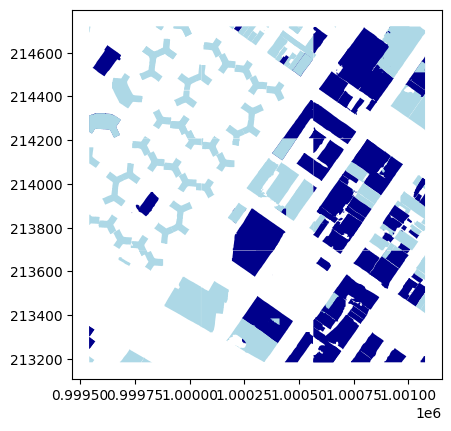

In [13]:
# Define output path for the shapefile
output_path = "predictions/predictions.shp"

# Create the shapefile using the coordinates and classes from the model's predictions
gdf = create_shapefile(predicted_xys, predicted_classes, output_path)

# Define colors for cool (1) and warm (0) roofs
color_mapping = {0: 'darkblue', 1: 'lightblue'}

# Map the predictions
gdf.plot(color=gdf['cool_roof'].map(color_mapping), legend=True)